In [37]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
from sklearn.metrics import f1_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
torch.manual_seed(99)

In [38]:
class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fix the size of the classifier layer
        self.classifier = nn.Linear(256*3*3, 10)  # Corrected size

        # Initialize weights
        nn.init.normal_(self.classifier.weight, 0, 0.01)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [39]:
transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [40]:
fashion_mnist_train = datasets.FashionMNIST(root='./FashionMNIST', train=True, download=True, transform=transformations)
fashion_mnist_test = datasets.FashionMNIST(root='./FashionMNIST', train=False, download=True, transform=transformations)

In [41]:
batch_size = 64
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

In [42]:
pretrained_model_cifar10 = torch.load('./models/cifar10_mini_vgg.pth', map_location=torch.device('cpu')) 
pretrained_model_mnist = torch.load('./models/cifar10_mini_vgg.pth', map_location=torch.device('cpu'))

In [43]:
print(pretrained_model_cifar10.keys())
print(pretrained_model_mnist.keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'classifier.weight', 'classifier.bias'])
odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'classifier.weight', 'classifier.bias'])


In [44]:
model_cifar10 = MiniVGG().to('cpu')
model_mnist = MiniVGG().to('cpu')

model_cifar10.load_state_dict(pretrained_model_cifar10)
model_mnist.load_state_dict(pretrained_model_mnist)

<All keys matched successfully>

In [45]:
model_cifar10.features[2].state_dict()

OrderedDict([('weight',
              tensor([[[[-2.2723e-07, -4.1959e-07, -1.2874e-08],
                        [-5.3820e-08, -3.5285e-08,  1.3085e-10],
                        [-4.0859e-10, -7.4913e-12, -1.3883e-12]],
              
                       [[-5.5253e-06, -7.9452e-08, -8.7202e-10],
                        [-7.8819e-08,  5.3957e-22,  2.6144e-20],
                        [-4.1700e-11,  1.7307e-22,  1.1922e-22]],
              
                       [[-1.6071e-03, -1.6438e-03, -1.3335e-03],
                        [-1.4851e-03, -1.5397e-03, -1.1648e-03],
                        [-2.0745e-03, -1.9272e-03, -1.7380e-03]],
              
                       ...,
              
                       [[-4.4844e-03, -4.6813e-03, -5.7477e-03],
                        [-5.8775e-03, -6.2364e-03, -7.1206e-03],
                        [-5.7861e-03, -6.4992e-03, -7.6280e-03]],
              
                       [[ 9.7775e-11,  2.9410e-18, -2.4413e-16],
                        

In [46]:
# freeze self.features and train self.classifier for 2 pretrained midels on FashionMnist
for param in model_cifar10.features.parameters():
    param.requires_grad = False

for param in model_mnist.features.parameters():
    param.requires_grad = False

model_cifar10.classifier.requires_grad = True
model_mnist.classifier.requires_grad = True

# train model_cifar10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cifar10.parameters(), lr=0.001)
num_epochs = 5
losses = []

def train(model, optimizer, criterion, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    plt.plot(losses)
    plt.show()

Epoch [1/5], Loss: 0.8064
Epoch [2/5], Loss: 0.1538
Epoch [3/5], Loss: 0.2695
Epoch [4/5], Loss: 0.2300
Epoch [5/5], Loss: 0.5269


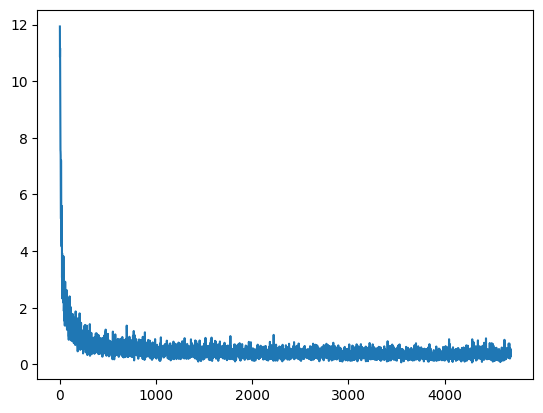

In [47]:
train(model_cifar10, optimizer, criterion, train_loader)

Epoch [1/5], Loss: 9.3533
Epoch [2/5], Loss: 11.5599
Epoch [3/5], Loss: 11.0160
Epoch [4/5], Loss: 14.2572
Epoch [5/5], Loss: 10.4374


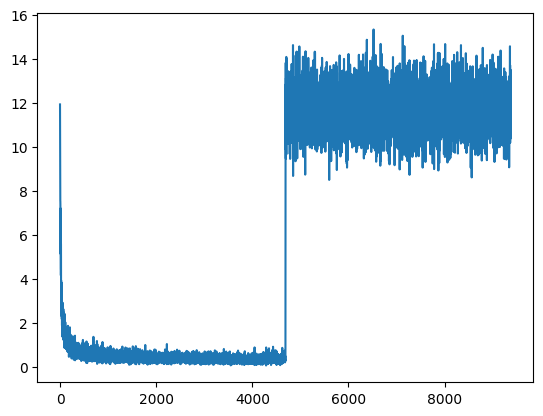

In [48]:
train(model_mnist, optimizer, criterion, train_loader)

# loss em quên init lại nên nó plot cả loss model cifar 10 nhưng cũng thấy được loss tệ đi thế nào

Epoch [1/5], Loss: 2.3025
Epoch [2/5], Loss: 2.3034
Epoch [3/5], Loss: 2.3020
Epoch [4/5], Loss: 2.3021
Epoch [5/5], Loss: 2.3021


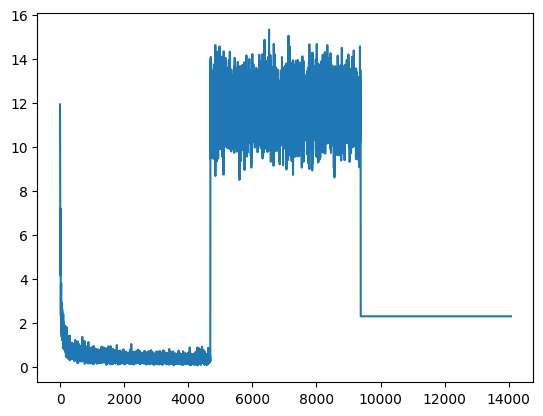

In [52]:
model_vgg = MiniVGG()
train(model_vgg, optimizer, criterion, train_loader)

In [49]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')



In [50]:
test(model_cifar10, test_loader)


Accuracy: 0.8747


In [51]:
test(model_mnist, test_loader)


Accuracy: 0.0598


In [53]:
test(model_vgg, test_loader)


Accuracy: 0.0997


# Em nghĩ lí do mnist pretrained model tệ vì nó được train để detect các số
# thay vì cifar-10 pretrained model được train trên có loại object
# vgg train từ đầu thì không tốt bằng sau khi finetune cifar-10 model